In [155]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [156]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [157]:
path = untar_data(URLs.MNIST_SAMPLE)

In [158]:
#hide
Path.BASE_PATH = path

In [159]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [160]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [161]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [162]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [163]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [164]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [165]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [166]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

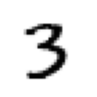

In [167]:
show_image(three_tensors[1]);

In [168]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [169]:
len(stacked_threes.shape)

3

In [170]:
stacked_threes.ndim

3

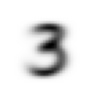

In [171]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

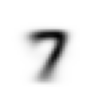

In [172]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

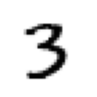

In [173]:
a_3 = stacked_threes[1]
show_image(a_3);

In [174]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [175]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [176]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [177]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [178]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [179]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [180]:
tns[1]

tensor([4, 5, 6])

In [181]:
tns[:,1]

tensor([2, 5])

In [182]:
tns[1,1:3]

tensor([5, 6])

In [183]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [184]:
tns.type()

'torch.LongTensor'

In [185]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [186]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [187]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [188]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1238, 0.1194, 0.1207,  ..., 0.1092, 0.1460, 0.1176]),
 torch.Size([1010]))

In [189]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [190]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [191]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [192]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [193]:
a = is_3(valid_3_tens).float()

In [194]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

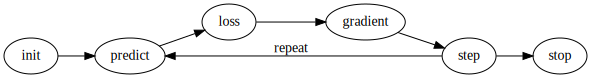

In [195]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [196]:
def f(x): return x**2

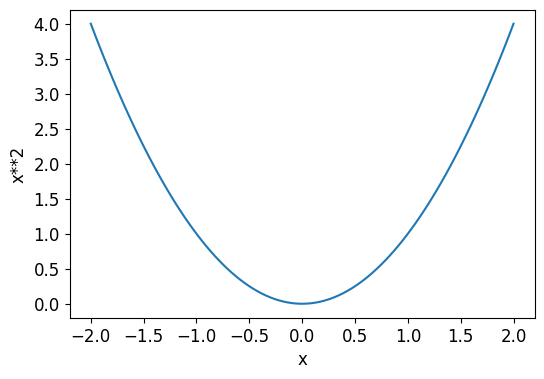

In [197]:
plot_function(f, 'x', 'x**2')

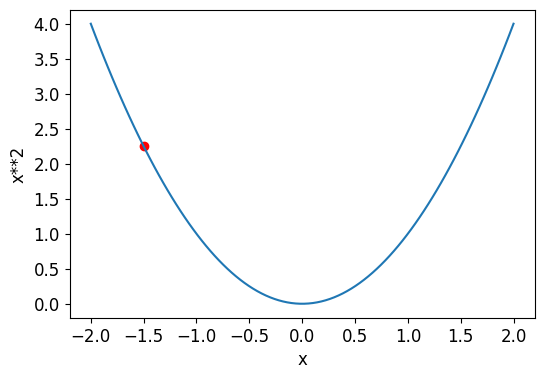

In [198]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [199]:
xt = tensor(3.).requires_grad_()

In [200]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [201]:
yt.backward()

In [202]:
xt.grad

tensor(6.)

In [203]:
a = tensor(5.38).requires_grad_()
b = a**2
b
#b.backward()
#a.grad

tensor(28.9444, grad_fn=<PowBackward0>)

In [204]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [205]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [206]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

tensor([ 1.0000,  0.9980,  0.9920,  0.9819,  0.9679,  0.9501,  0.9284,  0.9029,  0.8738,  0.8413,  0.8053,  0.7660,  0.7237,  0.6785,  0.6306,  0.5801,  0.5272,  0.4723,  0.4154,  0.3569,  0.2969,
         0.2358,  0.1736,  0.1108,  0.0476, -0.0159, -0.0793, -0.1423, -0.2048, -0.2665, -0.3271, -0.3863, -0.4441, -0.5000, -0.5539, -0.6056, -0.6549, -0.7015, -0.7453, -0.7861, -0.8237, -0.8580,
        -0.8888, -0.9161, -0.9397, -0.9595, -0.9754, -0.9874, -0.9955, -0.9995, -0.9995, -0.9955, -0.9874, -0.9754, -0.9595, -0.9397, -0.9161, -0.8888, -0.8580, -0.8237, -0.7861, -0.7453, -0.7015,
        -0.6549, -0.6056, -0.5539, -0.5000, -0.4441, -0.3863, -0.3271, -0.2665, -0.2048, -0.1423, -0.0792, -0.0159,  0.0476,  0.1108,  0.1736,  0.2358,  0.2969,  0.3569,  0.4154,  0.4723,  0.5272,
         0.5801,  0.6306,  0.6785,  0.7237,  0.7660,  0.8053,  0.8413,  0.8738,  0.9029,  0.9284,  0.9501,  0.9679,  0.9819,  0.9920,  0.9980,  1.0000])


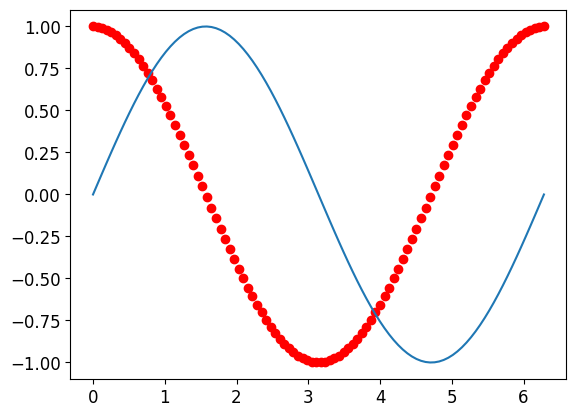

In [207]:
def sin(x): return torch.sin(x)
m = torch.linspace(0, 2*math.pi, 100)
plt.plot(m, sin(m))

m.requires_grad_()
o = sin(m).sum()
o.backward()
print(m.grad)
plt.scatter(m.detach(), m.grad.detach(), color='red');



tensor([-0.0000e+00, -6.3424e-02, -1.2659e-01, -1.8925e-01, -2.5115e-01, -3.1203e-01, -3.7166e-01, -4.2979e-01, -4.8620e-01, -5.4064e-01, -5.9291e-01, -6.4279e-01, -6.9008e-01, -7.3459e-01,
        -7.7615e-01, -8.1458e-01, -8.4973e-01, -8.8145e-01, -9.0963e-01, -9.3415e-01, -9.5490e-01, -9.7181e-01, -9.8481e-01, -9.9384e-01, -9.9887e-01, -9.9987e-01, -9.9685e-01, -9.8982e-01,
        -9.7880e-01, -9.6384e-01, -9.4500e-01, -9.2235e-01, -8.9599e-01, -8.6603e-01, -8.3257e-01, -7.9576e-01, -7.5575e-01, -7.1269e-01, -6.6677e-01, -6.1816e-01, -5.6706e-01, -5.1368e-01,
        -4.5823e-01, -4.0093e-01, -3.4202e-01, -2.8173e-01, -2.2031e-01, -1.5800e-01, -9.5056e-02, -3.1728e-02,  3.1728e-02,  9.5056e-02,  1.5800e-01,  2.2031e-01,  2.8173e-01,  3.4202e-01,
         4.0093e-01,  4.5823e-01,  5.1368e-01,  5.6706e-01,  6.1816e-01,  6.6677e-01,  7.1269e-01,  7.5575e-01,  7.9576e-01,  8.3257e-01,  8.6603e-01,  8.9599e-01,  9.2235e-01,  9.4500e-01,
         9.6384e-01,  9.7880e-01,  9.8982e-01,  9.

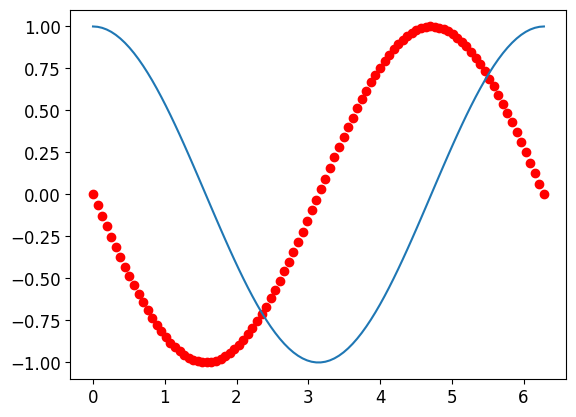

In [208]:
def cos(x): return torch.cos(x)
m = torch.linspace(0, 2*math.pi, 100)
plt.plot(m, cos(m))

m.requires_grad_()
o = cos(m).sum()
o.backward()
print(m.grad)
plt.scatter(m.detach(), m.grad.detach(), color='red');

Mean gradient: tensor([0.0000, 0.1266, 0.2511, 0.3717, 0.4862])
Sum gradient: tensor([1.0000, 0.9980, 0.9920, 0.9819, 0.9679])


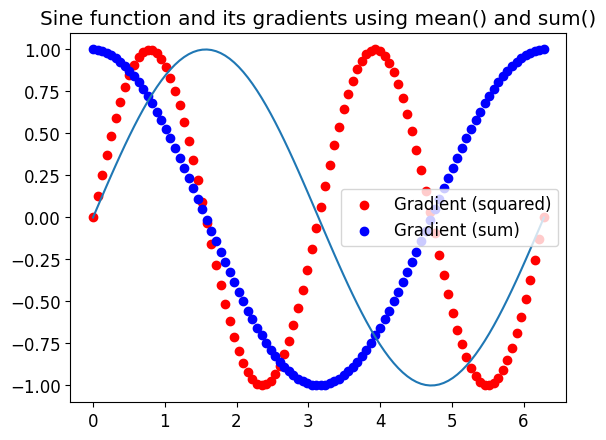

In [209]:
def sin(x): return torch.sin(x)
m = torch.linspace(0, 2*math.pi, 100)
plt.plot(m, sin(m))

m.requires_grad_()
o_mean = sin(m).pow_(2).sum()
o_mean.backward()
print('Mean gradient:', m.grad[0:5]) # Print first few elements for brevity
plt.scatter(m.detach(), m.grad.detach(), color='red', label='Gradient (squared)');

# Reset gradients for the sum operation
m.grad = None
o_sum = sin(m).sum()
o_sum.backward()
print('Sum gradient:', m.grad[0:5]) # Print first few elements for brevity
plt.scatter(m.detach(), m.grad.detach(), color='blue', label='Gradient (sum)');
plt.legend()
plt.title('Sine function and its gradients using mean() and sum()')
plt.show()

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [210]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

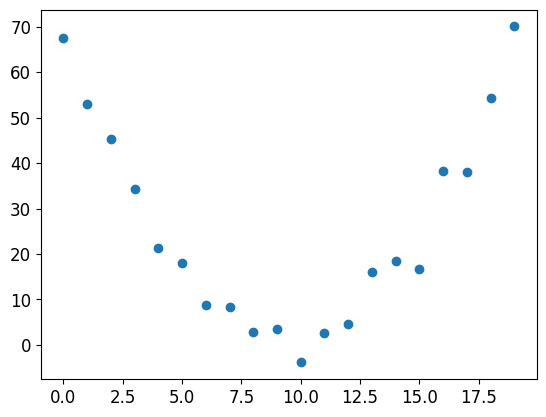

In [211]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [212]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [213]:
t = torch.randn(3)
a,b,c=t
a,b,c

(tensor(0.9024), tensor(0.3410), tensor(-0.6902))

In [214]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [215]:
params = torch.randn(3).requires_grad_()

In [216]:
#hide
orig_params = params.clone()
orig_params

tensor([-0.2801,  0.9275, -0.9955], grad_fn=<CloneBackward0>)

#### Step 2: Calculate the predictions

In [217]:
preds = f(time, params)
preds

tensor([ -0.9955,  -0.3480,  -0.2607,  -0.7335,  -1.7663,  -3.3593,  -5.5124,  -8.2257, -11.4990, -15.3324, -19.7260, -24.6797, -30.1935, -36.2674, -42.9014, -50.0955, -57.8497, -66.1641, -75.0385,
        -84.4731], grad_fn=<AddBackward0>)

In [218]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

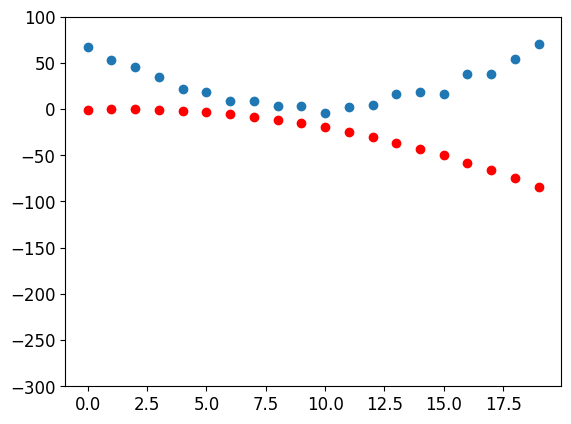

In [219]:
show_preds(preds)

#### Step 3: Calculate the loss

In [220]:
loss = mse(preds, speed)
loss

tensor(4336.1797, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [221]:
loss.backward()


In [222]:
params.grad * 1e-5


tensor([-0.2034, -0.0129, -0.0011])

In [223]:
params.grad, params.data

(tensor([-20340.7832,  -1292.3708,   -105.3313]),
 tensor([-0.2801,  0.9275, -0.9955]))

#### Step 5: Step the weights.

In [224]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [225]:
preds = f(time,params)
mse(preds, speed)

tensor(1355.4641, grad_fn=<MeanBackward0>)

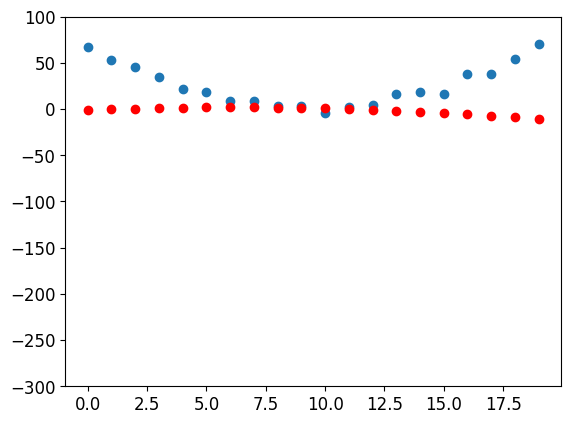

In [226]:
show_preds(preds)

In [227]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process

In [228]:
for i in range(10): apply_step(params)

1355.464111328125
791.4179077148438
684.6798095703125
664.4781494140625
660.6519775390625
659.924560546875
659.783447265625
659.7533569335938
659.7442016601562
659.7389526367188


In [229]:
#hide
params = orig_params.detach().requires_grad_()

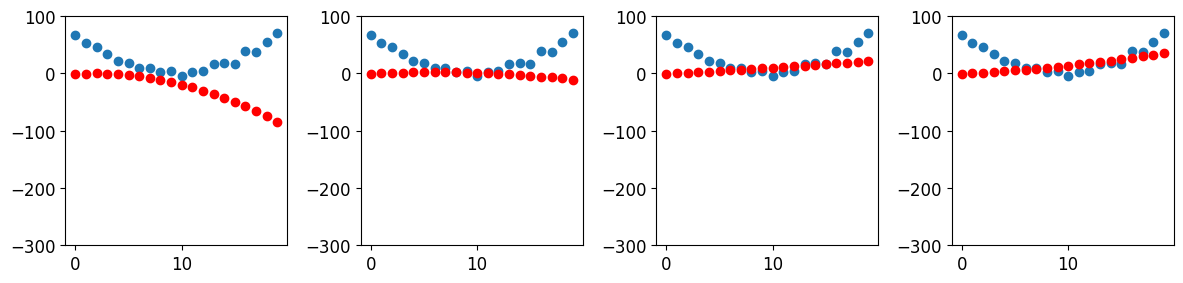

In [230]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

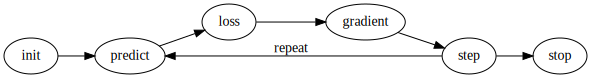

In [231]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [232]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [233]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [234]:
t = tensor([[1,2,3],[4,5,6]])
u = tensor([[1,2,3],[4,5,6]])
t1 = list(zip(t,u))
x,y = t1[0]
x.shape

torch.Size([3])

In [235]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
len(dset),x.shape,y

(12396, torch.Size([784]), tensor([1]))

In [236]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [237]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [238]:
weights = init_params((28*28,1))
weights.requires_grad


True

In [239]:
bias = init_params(1)
bias

tensor([0.0410], requires_grad=True)

In [240]:
(train_x[0]*weights.T).sum() + bias

tensor([7.3036], grad_fn=<AddBackward0>)

In [241]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 7.3036],
        [ 6.8004],
        [ 3.2970],
        ...,
        [-3.3111],
        [ 5.5018],
        [ 1.7542]], grad_fn=<AddBackward0>)

In [242]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [243]:
(preds>0.0).float()

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [1.],
        [1.]])

In [244]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [245]:
corrects.float().mean().item()

0.49612778425216675

In [246]:
with torch.no_grad(): weights[0] *= 1.0001

In [247]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.49612778425216675

In [248]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [249]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [250]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [251]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [252]:
mnist_loss(tensor([0.9, 0.2, 0.8]),trgts)

tensor(0.1667)

### Sigmoid

In [253]:
def sigmoid(x): return 1/(1+torch.exp(-x))

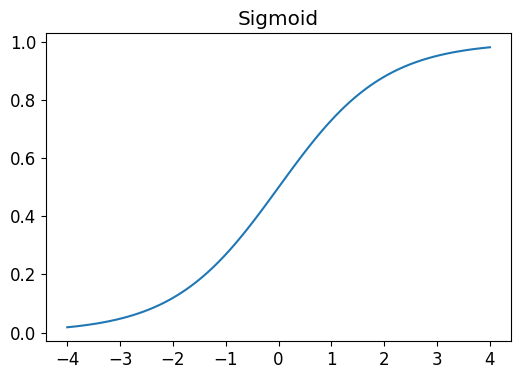

In [254]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [255]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [256]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([10,  4,  1,  2,  6]),
 tensor([ 8,  7,  9, 13, 11]),
 tensor([ 0, 12,  5, 14,  3])]

In [257]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j'),(10, 'k'),(11, 'l'),(12, 'm'),(13, 'n'),(14, 'o'),(15, 'p'),(16, 'q'),(17, 'r'),(18, 's'),(19, 't')...]

In [258]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 7,  4, 20, 19,  5, 25]), ('h', 'e', 'u', 't', 'f', 'z')),
 (tensor([22, 13, 18,  0,  6, 16]), ('w', 'n', 's', 'a', 'g', 'q')),
 (tensor([10,  1, 21,  8, 24, 17]), ('k', 'b', 'v', 'i', 'y', 'r')),
 (tensor([23, 14,  3, 12, 11,  2]), ('x', 'o', 'd', 'm', 'l', 'c')),
 (tensor([ 9, 15]), ('j', 'p'))]

## Putting It All Together


1.   weights and bias
2.   Dataloader and batch size from image dataset
3.   Train_x and train_y that are already inteh dataset
4.   predictions from linear1 function with initial weight and bias
5.   calculate gradient from  mnist_loss (applying sigmoid to being it between 0 and 1)
6.   calculate batch accuracy
7.   Update weights by learning rate
8.   one epoch is over  





In [259]:
weights = init_params((28*28,1))
bias = init_params(1)

In [260]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [261]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [262]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [263]:
preds = linear1(batch)
preds

tensor([[-10.2422],
        [ -8.0887],
        [ -6.5541],
        [-12.6930]], grad_fn=<AddBackward0>)

In [264]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9996, grad_fn=<MeanBackward0>)

In [265]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-6.3258e-05), tensor([-0.0004]))

In [266]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [267]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0001), tensor([-0.0009]))

In [268]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0002), tensor([-0.0013]))

In [269]:
weights.grad.zero_()
bias.grad.zero_();

In [270]:
def train_epoch_1(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [271]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [272]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [273]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [274]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [275]:
validate_epoch(linear1)

0.3663

In [276]:
lr = 1.
params = weights,bias
train_epoch_1(linear1, lr, params)
validate_epoch(linear1)

0.5686

In [277]:
for i in range(20):
    train_epoch_1(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.785 0.8798 0.913 0.9271 0.9349 0.9432 0.9486 0.9516 0.9555 0.9564 0.9584 0.9613 0.9628 0.9628 0.9638 0.9647 0.9647 0.9652 0.9667 0.9677 

### Creating an Optimizer

In [278]:
linear_model = nn.Linear(28*28,1)

In [279]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [280]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [281]:
opt = BasicOptim(linear_model.parameters(), lr)

In [282]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [283]:
validate_epoch(linear_model)

0.6881

In [284]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [285]:
train_model(linear_model, 20)

0.4932 0.7959 0.854 0.9165 0.935 0.9487 0.956 0.9638 0.9663 0.9682 0.9702 0.9717 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.979 

In [286]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7358 0.8613 0.9175 0.935 0.9497 0.958 0.9629 0.9658 0.9682 0.9707 0.9712 0.9736 0.9751 0.9761 0.977 0.9775 0.9775 0.9785 0.979 

In [287]:
dls = DataLoaders(dl, valid_dl)

In [288]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [289]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637515,0.503649,0.495584,00:00
1,0.606333,0.094786,0.943081,00:00
2,0.218787,0.243233,0.771835,00:00
3,0.094366,0.123906,0.895976,00:00
4,0.048433,0.085864,0.926889,00:00
5,0.030589,0.067116,0.942591,00:00
6,0.023281,0.055812,0.953386,00:00
7,0.020083,0.048421,0.960746,00:00
8,0.018512,0.043321,0.964671,00:00
9,0.017602,0.039627,0.966143,00:00


## Adding a Nonlinearity

In [290]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [291]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

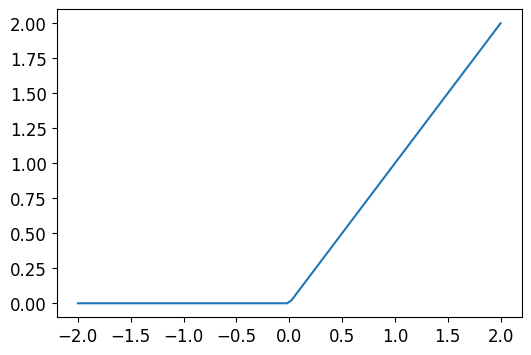

In [292]:
plot_function(F.relu)

In [293]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [294]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [295]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.350349,0.412192,0.505397,00:00
1,0.160197,0.242991,0.789500,00:00
2,0.086756,0.119633,0.914622,00:00
3,0.055792,0.079587,0.940137,00:00
4,0.041644,0.061665,0.956330,00:00
5,0.034527,0.051701,0.964181,00:00
6,0.030505,0.045454,0.965162,00:00
7,0.027931,0.041200,0.967615,00:00
8,0.026096,0.038117,0.968597,00:00
9,0.024684,0.035773,0.970559,00:00


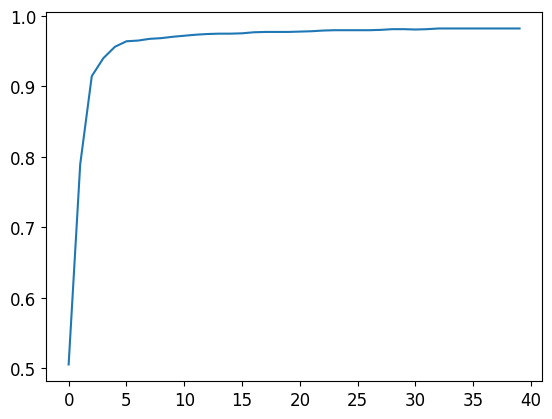

In [296]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [297]:
learn.recorder.values[-1][2]

0.98233562707901

### Going Deeper

In [298]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.124729,0.017869,0.996565,02:50


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.